# Cython

Being a C program itself, Python has a powerful and well developed C API, which allows writing C extensions. However, Python C API is considered an advanced tool and native development of C extensions is slow and error-prone.

Cython is a static compiler for Python. It allows writing Python C extensions with less effort compared to traditional Python C API way.

General Cython pipeline looks as the following:

- you develop some code in pure Python and **profile** it with `line_profiler` (or alike) to catch hotspots,
- you decide on the strategy to optimize your code. Typically, this would involve transforming PYthon code to Cython code by **adding type information**, and using **typed memoryviews** instead of NumPy arrays,
- then you generate C extension module from Cython code and test its performance. If it ok - end of the story, if it's not, you continue.

Cython knows a lot about NumPy arrays and allows interfacing with them easily. Cython code itself looks a lot like a mixture of C and Python. Cython compiler generates C extensions code from Cython code and compiles it with system compiler as a loadable C extension.

In this material, we will use `Cython` extension for Jupyter to avoid writing modules and compile them with `setup.py` (although that's also simple enough). This may not work on Windows very well, as Cython requires C compiler to generate extension modules from C code, and it is sometimes tricky to setup correctly on Windows.

# Matrix multiplication

We will implement matrix multiplication using Cython. We'll start with naive and straightforward implementation, measure it's performance and compare it with `np.dot` performance. Then, we will try to improve it using smarter memory access pattern.

In [1]:
%pylab inline
plt.style.use('bmh')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


As you can see, NumPy uses system linear algebra libraries (OpenBLAS in this case, but it may Intel MKL or something else) and it is usually much slower without them. Those libraries contain highly optimized and well-tested code, which very often leverages available CPU features (SSE, AVX, etc.) to make computation as efficient as possible. Note, that your machine may show different libraries, and it's only important that you see **something** and not pure NumPy implementation.

In real world you will often optimize custom algorithms with Cython, not simple linear algebra operations, so we won't compete with decades of linear algebra routines development. Instead, we want to know a) what we're comparing against, b) what we can achieve with Cython compared to naive Python implementations.

We need some tools to measure performance, so that we can plot running time to see the pattern. Although there are many different ways to do this, we will use `%timeit`. Note, that we can catch output of `%timeit`:

In [3]:
arr = np.random.randn(1000,1000)

In [4]:
# Returns TimeitResult object
s = %timeit -n 10 -r 3 -o np.dot(arr, arr)

15.9 ms ± 1.8 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [5]:
s.average

0.015911228066882662

## Problem with matrix multiplication

Product of matrices $A$ and $B$ is a matrix $C$:

$$C_{ik} = A_{ij}B_{jk}.$$

You can immediately spot the problem here. If both matrices are in row-major order, $B$ is accessed in wrong direction: you hop through array rows, which leads to a lot of cache misses.

Anyway, it's interesting to understand, how naive implementation performs. Let's do that.

## Typed memoryviews

To represent homogeneous buffers of data (which NumPy arrays are) in Cython, we have what is called [_typed memoryview_](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html). Typed memoryview is a handle to underlying buffer of Python object, if there's a buffer, of course (`array` from standard library will work as well). Consult typed memoryviews docs to understand the declaration structure.

We first import `Cython` extension. `Cython` extension does all the job for us: generates C extension module, compiles it and loads the function as needed.

In [6]:
%load_ext Cython

To see some hints from Cython we will use **annotations** (`--annotate` key). With this option, Cython will mark all the Python interaction in yellow. Generally, using functions from Python interpreter itself should be avoided, as they go throught Python stack and are hence slow. You can click on `+` in the output to see the actual C code generated by Cython.

`%cython` magic will do all the underlying work (generating C extension, compiling it and loading it) for us:

In [7]:
%%cython --annotate

# In this function we have memoryview of buffer of doubles as an argument
def sum_arr(double[:] a):
    """Sum elements of `a`."""

    result = 0.

    # Note, that typed memoryviews know about shape
    for i in range(a.shape[0]):
        result += a[i]
    return result

Let's check that computation is correct:

In [8]:
# BTW, why do we need to flatten our array?
arr_f = arr.flatten()
sum_arr(arr_f), arr.sum()

(-909.5667866823576, -909.5667866824264)

And measure how it compares to NumPy:

In [9]:
%timeit -n 100 -r 3 sum_arr(arr_f)

18 ms ± 73.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [10]:
%timeit -n 100 -r 3 arr.sum()

293 µs ± 60.3 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


As you can see, not only our function is much slower, but it's also (see annotation) a bit too Pythonic. It uses usual Python `float` functions to add new element value to `result`.

You should be careful enough using the tools below, but generally it's quite safe to use them with typed memoryviews (but remember, that other objects may also be in scope, those, which do not know about their shape). So, we will skip bounds check. Wow, right?

We will also make result a usual C `double`.`@boundscheck(False)` decorator skips all checks, related to whether you're accessing your buffer within bounds. `@wraparound` decorator deactivates negative indexing, as we do not use them and there's no need to check is they are used correctly:

In [11]:
%%cython --annotate
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
def sum_arr_c(double[:] a):
    """Sum elements of `a`."""

    cdef double result = 0.

    # Note, that typed memoryviews know about shape
    for i in range(a.shape[0]):
        result += a[i]
    return result

Much better, right? Take some time to try to understand C code in annotations and get the idea about the difference between two versions of the function.

In [12]:
sum_arr(arr_f), sum_arr_c(arr_f), arr.sum()

(-909.5667866823576, -909.5667866823576, -909.5667866824264)

In [13]:
%timeit -n 100 -r 3 sum_arr_c(arr_f)

1.03 ms ± 58.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Note, that Cython does transformation from C `double` to Python `float` for you:
    
```c
__pyx_t_5 = PyFloat_FromDouble(__pyx_v_result); if (unlikely(!__pyx_t_5)) __PYX_ERR(0, 12, __pyx_L1_error)
```

Note, that one type annotation and two decorators speed up computation by an order of magnitude.

BTW, do you understand, why results between our function and `np.sum` are slightly different? Think about this for a moment (or Google it!).

So, we have a function, which is still slightly worse, than `numpy` equivalent. But we got here without a lot of efforts.

As a side note: our summation function can be implemented in `numpy` array specific way (and it  then won't work with standard Python arrays, for example):

In [14]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def sum_arr_np(np.ndarray[np.float64_t, ndim=1] a):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i

    # numpy arrays also know about shape, of course
    for i in range(a.shape[0]):
        result += a[i]
    return result

In [15]:
%timeit -n 100 -r 3 sum_arr_np(arr_f)

1.06 ms ± 77.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Now that we know something about Cython and typed memoryviews, we can go on and try to implement matrix multiplication!

# Implementing matrix product

We'll do the naive version of matrix multiplication, which just implements general formula for matrix product. Although naive, we'll add some optimizations later to have better memory access.

In [16]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult(double[:, :] a, double[:, :] b):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
        
    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum
    cdef int i, j, k
    cdef double ak, bk

    # Outer loop: rows of a
    for i in range(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                accum += a[i, k]*b[k, j]
            result[i, j] = accum
    return np.asarray(result)

Our function is quite C-ish. But is it fast?

In [17]:
a = np.random.randn(300, 500)
b = np.random.randn(500, 700)

In [18]:
np.allclose(mat_mult(a, b), np.dot(a, b))

True

In [19]:
%timeit -n 10 -r 3 mat_mult(a, b)

110 ms ± 1.46 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [20]:
%timeit -n 10 -r 3 np.dot(a, b)

2.79 ms ± 371 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


Not that fast, right? Why our function is so slow? Let's perform an experiment. We will change the way `b` is stored, so that indexing order for `b` is efficient:

In [21]:
b_t = np.asfortranarray(b)

In [22]:
%timeit -n 10 -r 3 mat_mult(a, b_t)

104 ms ± 2.66 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Timing should be somewhat smaller now. By default, arrays are stored in C-order (row-major), so that stride for last array dimension is the smallest. If we change that to F-order, we suddenly make memory access for `b` much more efficient. Add this to our function, so that we do not need to do it manually, but first let's check how expensive the operation is:

In [23]:
%timeit -n 10 -r 3 np.asfortranarray(b)

393 µs ± 117 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [24]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult_t(double[:, ::1] a, double[:, ::1] b):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?

    cdef double[::1, :] b_t = np.asfortranarray(b)
        
    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int i, j, k

    # Outer loop: rows of a
    for i in range(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b_t.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                accum += a[i, k]*b_t[k, j]
            result[i, j] = accum
    return np.asarray(result)

In [25]:
%timeit -n 10 -r 3 mat_mult_t(a, b)

101 ms ± 2.27 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [26]:
np.allclose(mat_mult_t(a, b), np.dot(a, b))

True

Let's investigate, how running time depends on matrix shape:

In [27]:
# New cool package here: now we have nice progress bars
from tqdm import tqdm

In [28]:
timings = []

for i in tqdm(range(32, 576, 64)):
    c = np.random.randn(i, i)
    t_np = %timeit -n 10 -r 3 -o -q np.dot(c, c)
    t_cy = %timeit -n 10 -r 3 -o -q mat_mult_t(c, c)
    timings.append([i, t_np.average, t_cy.average])

100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


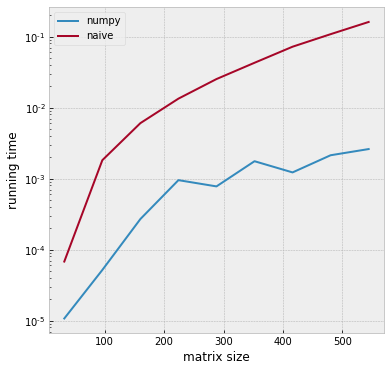

In [29]:
timings = np.array(timings)

plt.figure(figsize=(6,6))
plt.plot(timings[:, 0], timings[:, 1], label='numpy')
plt.plot(timings[:, 0], timings[:, 2], label='naive')
plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('matrix size')
plt.ylabel('running time');

So, our function is two orders of magnitude slower compared to NumPy `np.dot`. This, however, is expected, as we are using the most straightforward and simple approach.

On the next step we may try to implement [tiled matrix multiplication](https://penny-xu.github.io/blog/tiled-matrix-multiplication). But is it worth it? I'll provide an implementation, so that you can try, but generally our access pattern is already good enough for cache.

# Intermezzo on `range` in `for` loops

Cython is smart enough to smash Python `for` loops into plain C `for` loops. This allows for eliminating `StopIteration` exception on each iteration, thus, speeding things up a lot. However, Cython is only able to do this with `range(start, stop)`, while for `range(start, stop, step)` it needs to know the sign of `step`. If there's no way to determine the sign (at compile time!), Cython will default to Python-native loop.

Let's compare two implementations of array summation routine:

In [30]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def sum_arr(np.ndarray[np.float64_t, ndim=1] a):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i

    # numpy arrays also know about shape, of course
    for i in range(a.shape[0]):
        result += a[i]
    return result

@boundscheck(False)
@wraparound(False)
def sum_arr_step(np.ndarray[np.float64_t, ndim=1] a, int step):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i

    # numpy arrays also know about shape, of course
    for i in range(0, a.shape[0], step):
        result += a[i]
    return result

As you can see, `for` loop in `sum_arr` is ok, while very similar loop in `sum_arr_step` is highlighted with yellow (press `+` to see how Python `for` loop looks like compared to simple C-style loop).

In [31]:
plain_arr = np.random.randn(50000)
step_arr = np.random.randn(200000)

In [32]:
%timeit -n 100 -r 3 sum_arr(plain_arr)

52.6 µs ± 1.31 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [33]:
%timeit -n 100 -r 3 sum_arr_step(step_arr, 4)

873 µs ± 21.9 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


As you can see, `sum_arr_step` is 8 times (!) slower, although it performs the same number of calculations. This can be mitigated by helping Cython to generate efficient code:

In [34]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def sum_arr_step_opt(np.ndarray[np.float64_t, ndim=1] a, int step):
    """Sum elements of `a`."""

    cdef double result = 0.
    cdef int i, idx
    cdef int num_steps = a.shape[0] // step + int(a.shape[0] % step != 0)

    # numpy arrays also know about shape, of course
    for i in range(num_steps):
        idx = i * step
        result += a[idx]
    return result

In [35]:
sum_arr_step_opt(step_arr, 7), step_arr[::7].sum()

(-193.719046082307, -193.71904608230693)

In [36]:
%timeit -n 100 -r 3 step_arr[::4].sum()

32.2 µs ± 1.31 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [37]:
%timeit -n 100 -r 3 sum_arr_step_opt(step_arr, 4)

55.6 µs ± 3.99 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


Performance is now comparable (and you now understand how punitive to performance are Python loops).

## Tiled matrix multiplication

In [38]:
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

In [39]:
%%cython --annotate

from cython cimport boundscheck, wraparound
import numpy as np
cimport numpy as np

@boundscheck(False)
@wraparound(False)
def mat_mult_tiled(double[:, ::1] a, double[:, ::1] b,
                   size_t tile_t):
    """Calculate matrix product."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?


    cdef double[::1, :] b_t = np.asfortranarray(b)

    cdef double[:, :] result = np.zeros((a.shape[0], b.shape[1]))
    cdef double accum, ak, bk
    cdef int ait, ajt, at_dim_0, at_dim_1, ai, aidx, ajdx, bidx
    cdef int bit, bjt, bt_dim_0, bt_dim_1, bj, k, kdim
    cdef int num_tiles_a0 = a.shape[0] // tile_t + int(a.shape[0] % tile_t != 0)
    cdef int num_tiles_a1 = a.shape[1] // tile_t + int(a.shape[1] % tile_t != 0)
    cdef int num_tiles_b = b.shape[1] // tile_t + int(b.shape[1] % tile_t != 0)

    # Outer loop: row tile of a
    for aidx in range(num_tiles_a0):
        ait = aidx * tile_t
        at_dim_0 = min(tile_t,  a.shape[0] - ait)

        # First inner loop: column tile of b
        for bidx in range(num_tiles_b):
            bjt = bidx * tile_t
            bt_dim_1 = min(tile_t,  b.shape[1] - bjt)
            
            # Second inner loop: column tile of a
            for ajdx in range(num_tiles_a1):
                ajt = ajdx * tile_t
                at_dim_1 = min(tile_t,  a.shape[1] - ajt)
                
                # Tile matrix multiplication
                for ai in range(ait, ait+at_dim_0):
                    for bj in range(bjt, bjt+bt_dim_1):
                        accum = 0
                        for k in range(at_dim_1):
                            accum += a[ai, ajt+k]*b_t[ajt+k, bj]
                        result[ai, bj] += accum
    return np.asarray(result)

In [40]:
%timeit -n 3 -r 3 mat_mult_tiled(a, b, 32)

97.5 ms ± 958 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [41]:
np.allclose(mat_mult_tiled(a, b, 128), np.dot(a, b))

True

Let's consider different tiles:

In [42]:
tile_timings = []

for i in tqdm(range(16, 256, 16)):
    c = np.random.randn(512, 512)
    t_cy = %timeit -n 10 -r 3 -o -q mat_mult_tiled(c, c, i)
    tile_timings.append([i, t_cy.average])

100%|██████████| 15/15 [01:04<00:00,  4.31s/it]


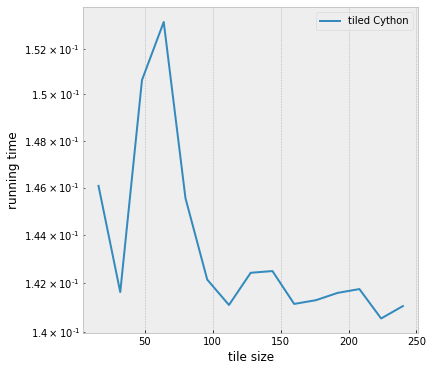

In [43]:
tile_timings = np.array(tile_timings)

plt.figure(figsize=(6,6))
plt.plot(tile_timings[:, 0], tile_timings[:, 1], label='tiled Cython')
plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('tile size')
plt.ylabel('running time');

In [44]:
tile_timings = []

for i in tqdm(range(32, 576, 64)):
    c = np.random.randn(i, i)
    t_cy_tiled = %timeit -n 10 -r 3 -o -q mat_mult_tiled(c, c, 32)
    tile_timings.append([i, t_cy_tiled.average])

100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


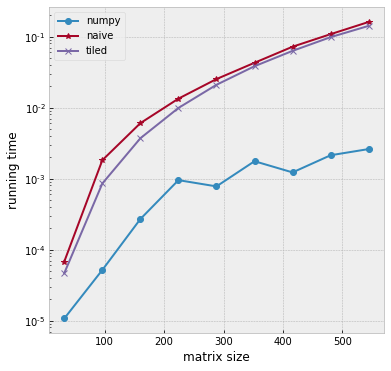

In [45]:
tile_timings = np.array(tile_timings)

plt.figure(figsize=(6,6))
plt.plot(timings[:, 0], timings[:, 1], "-o", label='numpy')
plt.plot(timings[:, 0], timings[:, 2], "-*", label='naive')
plt.plot(tile_timings[:, 0], tile_timings[:, 1], "-x", label='tiled')
plt.yscale('log')
plt.legend(loc=0)
plt.xlabel('matrix size')
plt.ylabel('running time');

As you can see, there was no need to add tiling for matrices of size we use. However, tiling is extremely important for matrix multiplication on GPU, as it allows for efficient use of hardware by leveraging shared memory.

# All at once

For comparison, let's create Numba version to see, what we can get for free. Numba is a JIT compiler for Python. In its basic form it allows to add a JIT decorator to any function, and that function will be JIT-compiled. However, Numba works great with NumPy, but cannot optimize Pandas.

In [46]:
import numba
from numba import jit, prange

@jit(parallel=True)
def mat_mult_numba(a, b):
    """Sum elements of `a`."""

    # Add some code to check dimensions here
    # We really need to check dimensions of matrices
    # Cause we disabled bounds check
    # a.shape[1]==b.shape[0]?
        
    result = np.zeros((a.shape[0], b.shape[1]))

    # b_t code here

    # Outer loop: rows of a
    for i in prange(a.shape[0]):
        # First inner loop: columns of b
        for j in range(b.shape[1]):
            accum = 0
            # Inner loop: product of row i of a and column j of b
            for k in range(a.shape[1]):
                ak = a[i, k]
                bk = b[k, j]
                accum += ak*bk
            result[i, j] = accum
    return result

In [47]:
%timeit -n 10 -r 3 np.dot(a, b)

2.9 ms ± 197 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [48]:
%timeit -n 10 -r 3 mat_mult_t(a, b)

119 ms ± 2.43 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [49]:
%timeit -n 10 -r 3 mat_mult_tiled(a, b, 32)

107 ms ± 883 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [51]:
%timeit -n 10 -r 3 mat_mult_numba(a, b)

15.2 ms ± 761 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


On instructor's machine (6-core) the results are the following:

- `np.dot`: **~3ms**,
- naive Cython implementation with `b` in F-order layout: **~120ms**,
- tiled Cython implementation with `b` in F-order layout: **~110ms**,
- parallel Numba implementation: **~15ms**.

Although it's hard to beat NumPy, we were close enough with very simple implementation. For custom algorithms Cython may be indispensable, and even more so - for wrapping available C libraries, as it allows linking to them. This is possible, because Cython generates C code, and everything (or, better to say, almost everything), which is possible to use in any C code, is available in Cython.